In [135]:
import kagglehub
# Download latest version
path = kagglehub.dataset_download("meowmeowmeowmeowmeow/gtsrb-german-traffic-sign")

print("Path to dataset files:", path)




Path to dataset files: /Users/gracebelmonte/.cache/kagglehub/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign/versions/1


In [136]:
print(path)

/Users/gracebelmonte/.cache/kagglehub/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign/versions/1


In [137]:
# check the folder structure 


import os
from pathlib import Path 

dataset_path = Path(path) 

print("Dataset path exists:", dataset_path.exists())
print("Top-level folder/files:")

for item in os.listdir(dataset_path):
    print("-", item)

Dataset path exists: True
Top-level folder/files:
- .DS_Store
- Test
- Test.csv
- Meta
- Train
- Meta.csv
- Train.csv


In [138]:
# check PyTorch # note that my Mac GPU is not active 
import torch
import torchvision

print(torch.__version__)
print(torchvision.__version__)
print("MPS available:", torch.backends.mps.is_available())



2.9.1
0.24.1
MPS available: False


In [148]:
import os
from pathlib import Path

dataset_path = Path(path)

train_dir = dataset_path / "Train"
test_dir = dataset_path / "Test"

print("Train folder exists:", train_dir.exists())
print("Test folder exists:", test_dir.exists())


Train folder exists: True
Test folder exists: True


In [140]:
# load the train.csv metadata 

import pandas as pd

train_csv = pd.read_csv(dataset_path / "Train.csv")
test_csv = pd.read_csv(dataset_path / "Test.csv")

train_csv.head()


,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,27,26,5,5,22,20,20,Train/20/00020_00000_00000.png
1,28,27,5,6,23,22,20,Train/20/00020_00000_00001.png
2,29,26,6,5,24,21,20,Train/20/00020_00000_00002.png
3,28,27,5,6,23,22,20,Train/20/00020_00000_00003.png
4,28,26,5,5,23,21,20,Train/20/00020_00000_00004.png


we can see that the images' width and height vary slightly (eg. 27x26, 29x26), this confirms that GTSRB images do not all have the same resolution, which means we must resize them during preprocessing. 
panda function: "https://www.naukri.com/code360/library/import-pandas-as-pd"

In [141]:
# check for missing values 

print("Missing values in training set:")
print(train_csv.isnull().sum())

print("\nMissing values in test set:")
print(test_csv.isnull().sum())



Missing values in training set:
Width      0
Height     0
Roi.X1     0
Roi.Y1     0
Roi.X2     0
Roi.Y2     0
ClassId    0
Path       0
dtype: int64

Missing values in test set:
Width      0
Height     0
Roi.X1     0
Roi.Y1     0
Roi.X2     0
Roi.Y2     0
ClassId    0
Path       0
dtype: int64


We can see there are no missing valyes in either the training or test metadata cvs - yay. 

In [142]:
# analyse class distribution 

# Count images per class
class_counts = train_csv['ClassId'].value_counts().sort_index()

print("Images per class:")
class_counts


Images per class:


ClassId
0      210
1     2220
2     2250
3     1410
4     1980
5     1860
6      420
7     1440
8     1410
9     1470
10    2010
11    1320
12    2100
13    2160
14     780
15     630
16     420
17    1110
18    1200
19     210
20     360
21     330
22     390
23     510
24     270
25    1500
26     600
27     240
28     540
29     270
30     450
31     780
32     240
33     689
34     420
35    1200
36     390
37     210
38    2070
39     300
40     360
41     240
42     240
Name: count, dtype: int64

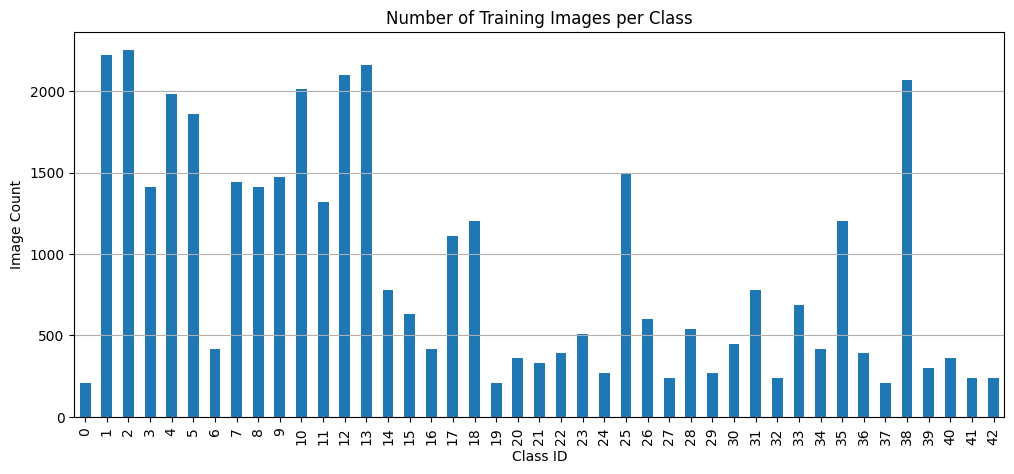

In [128]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
class_counts.plot(kind='bar')
plt.title("Number of Training Images per Class")
plt.xlabel("Class ID")
plt.ylabel("Image Count")
plt.grid(axis='y')
plt.show()


In [143]:
# analyse image sizes

from PIL import Image
import os
sizes = []

for fname in train_csv['Path']:   # the CSV includes image paths
    img_path = dataset_path / fname
    img = Image.open(img_path)
    sizes.append(img.size)

# Show the first 10 sizes
sizes[:10]



[(27, 26),
 (28, 27),
 (29, 26),
 (28, 27),
 (28, 26),
 (31, 27),
 (31, 28),
 (31, 28),
 (31, 29),
 (34, 32)]

In [144]:
# define the preprocessing transforms 

# run this to find the global per channel (R,G,B) mean and std that we should use 

from torchvision.models import ResNet50_Weights

weights = ResNet50_Weights.DEFAULT
print(weights.transforms())

ImageClassification(
    crop_size=[224]
    resize_size=[232]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


reference = https://docs.pytorch.org/vision/stable/models.html#transforms
note - maybe we are using resnet 18 instead, but probs an easy change 

we retrived the imageNet mean and sd values bceuase the pre trained models like ResNet 50 expect input images to be normalised using these excat statistics. 

In [152]:
# pre-processing pipeline

from torchvision import transforms

# Standard ImageNet normalization values
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std  = [0.229, 0.224, 0.225]

#train transform and this includes Nevas EDA findings 

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # resize all images to 224×224
    transforms.RandomRotation(20),
    transforms.RandomAffine(0, translate=(0.1, 0.1)),
    transforms.ColorJitter(brightness=0.2), 
    transforms.ToTensor(),           # convert PIL image -> tensor
    transforms.Normalize(imagenet_mean, imagenet_std)
])

#validation test transform (no augmentation)
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])


ToTensor ref = "https://docs.pytorch.org/vision/main/_modules/torchvision/transforms/transforms.html#ToTensor"
(also from the lab)
Torchvision. transformations = "https://docs.pytorch.org/vision/stable/transforms.html"
we used ToTensor() as it converts each image from a PIL/ NumPy format into a PyTorch tensor, which is the format required by PyTorch models.  

The augmentations where chosen based on Nevas EDa findings , to simulate real driving conditions. 
And there is no augmentation for validation/test since we only want to masure true model performance, so val/test transforms use only resize, tensor conversion, normalisation. 

This step is helping us prepare the raw GTSRB images for training a CNN/ Transfer learning model. 

In [153]:


# building a pytorch dataset class 

import torch
from torch.utils.data import Dataset
from PIL import Image 
import os 

class GTSRBDataset(Dataset):
    def __init__(self, df, root_dir, transform=None):
        self.df = df.reset_index(drop=True)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.root_dir, row["Path"])
        img = Image.open(img_path).convert("RGB")
        label = row["ClassId"]

        if self.transform:
            img = self.transform(img)

        return img, label


In [151]:
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(
    train_csv,
    test_size=0.2,
    stratify=train_csv["ClassId"],
    random_state=42
)


this code defines a custom PyTorch dataset that loads images listed in a CSV file, applies transforms and returns them with their labels so a DataLoader can feed them into a neural network during training. 

In [156]:
# make train/val/test dataset objects 

from sklearn.model_selection import train_test_split


train_df, val_df= train_test_split(
    train_csv,
    test_size=0.2,
    stratify= train_csv["ClassId"],
    random_state=42
)

here we have split our 39,000 training images into, 80% training, 20% validation. This stratefied split ensures imbalance does not harm model evaluation

In [157]:
#dataset objects 

root = dataset_path 

train_dataset = GTSRBDataset(train_df, root_dir=root, transform= train_transform)
val_dataset = GTSRBDataset(val_df, root_dir=root, transform=test_transform)
test_dataset = GTSRBDataset(test_csv, root_dir=root, transform=test_transform)



In [161]:
#dataloaders 

from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
